In [2]:
import math
from pycocotools.coco import COCO
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import torch
import torch.utils.data as data
from collections import defaultdict
import json
import os
import sys
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
import nltk
import os.path
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from nltk.corpus import stopwords
import cv2
from PIL import Image
import string
import seaborn as sns
import pandas as pd
from torchvision.models import ResNet50_Weights
from tqdm import tqdm



c:\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
# dataset dir path
cocoapi_dir = r"D:\DLproject\coco2017"

import os
folders = [folder for folder in os.listdir(cocoapi_dir)]
folders

['annotations', 'images']

## Data Visualization

In [ ]:
ann_file = os.path.join(cocoapi_dir, "annotations/captions_train2017.json")
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


Sample Captions: ['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.', 'A man riding on the back of a motorcycle.', 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'A man in a red shirt and a red hat is on a motorcycle on a hill side.']


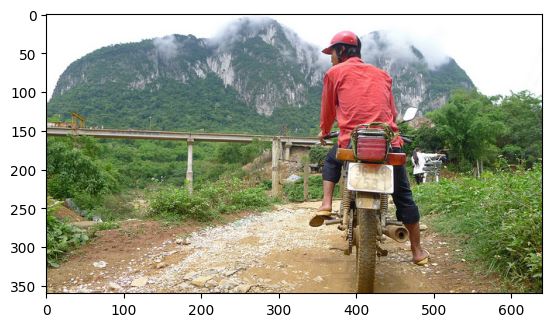

In [ ]:
image_ids = list(coco.imgs.keys())

sample_img_id = image_ids[0]  
ann_ids = coco.getAnnIds(imgIds=sample_img_id)  
captions = [coco.anns[ann]['caption'] for ann in ann_ids]  
img_info = coco.imgs[sample_img_id]
img_path = os.path.join(cocoapi_dir, "images/train2017", img_info['file_name'])
image = Image.open(img_path)
plt.imshow(image)
print("Sample Captions:", captions)


In [ ]:
num_images = len(image_ids)
num_captions = sum([len(coco.getAnnIds(imgIds=img_id)) for img_id in image_ids])

print(f"Total Images: {num_images}")
print(f"Total Captions: {num_captions}")

first_image = coco.imgs[image_ids[0]]
print("Sample Image Metadata:", first_image)



Total Images: 118287
Total Captions: 591753
Sample Image Metadata: {'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}


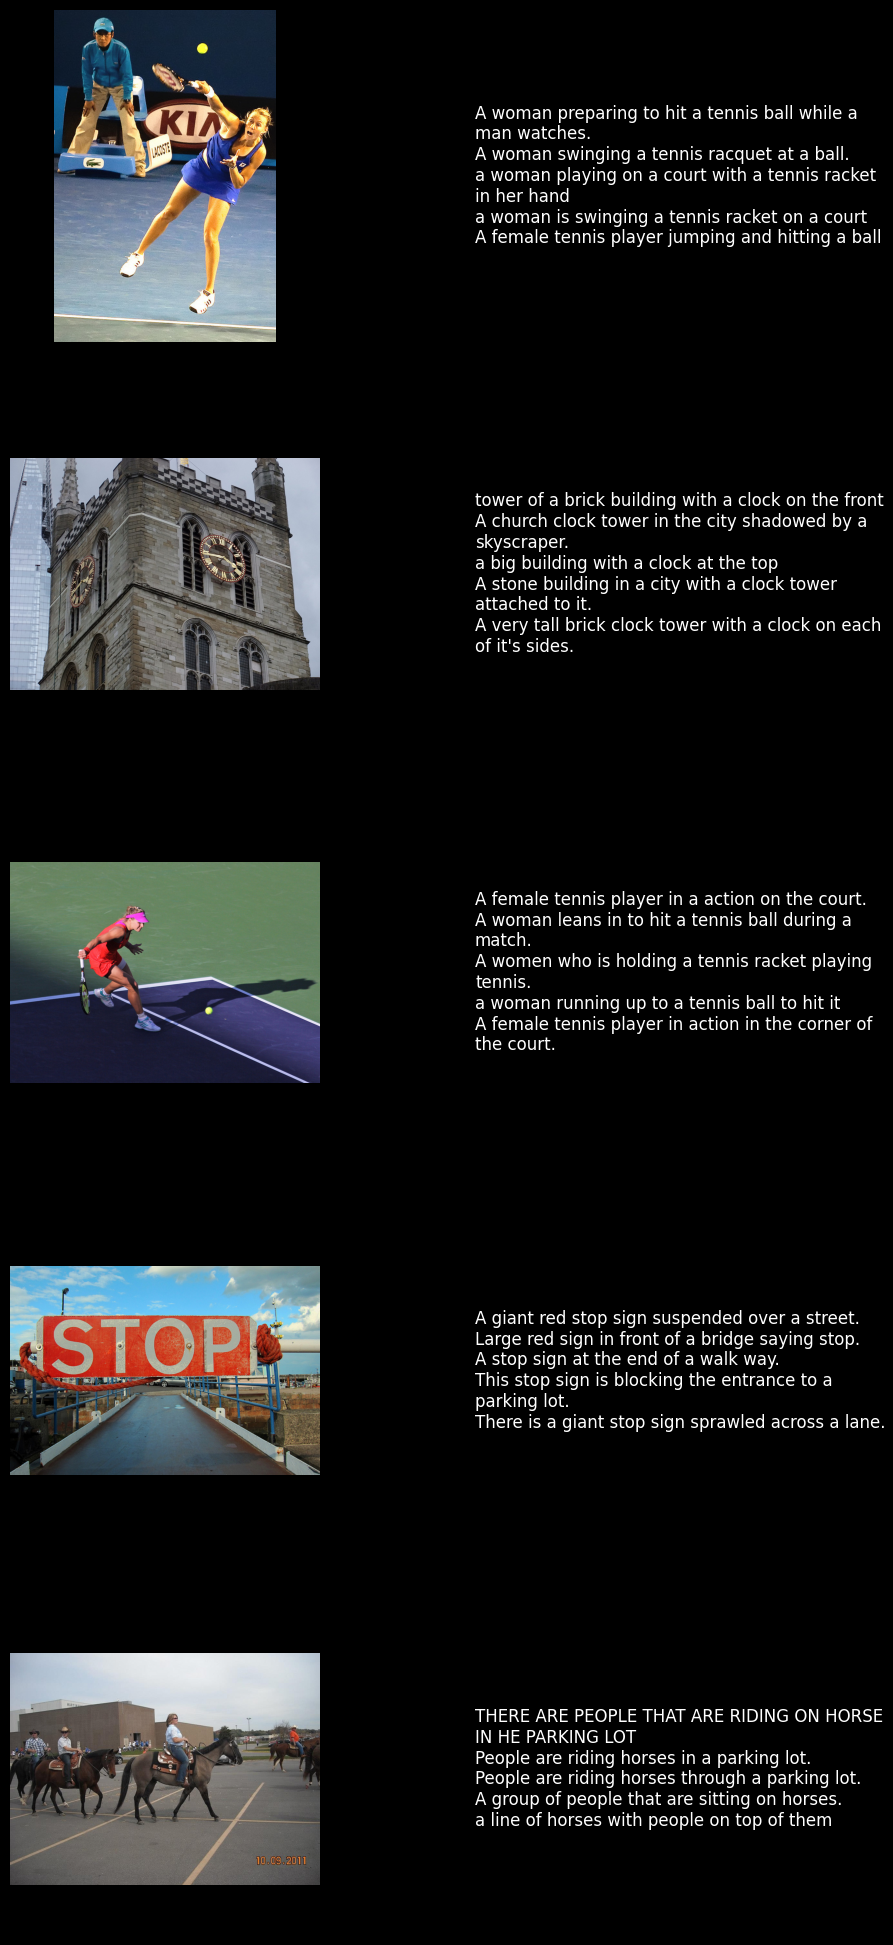

In [ ]:
def show_sample_images(num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))  
    fig.patch.set_facecolor('black')  

    for i in range(num_samples):
        img_id = random.choice(image_ids)
        img_info = coco.imgs[img_id]
        img_path = os.path.join(cocoapi_dir, "images/train2017", img_info['file_name'])

        image = Image.open(img_path)
        axes[i, 0].imshow(image)
        axes[i, 0].set_facecolor('black')  
        axes[i, 0].axis('off')  

        ann_ids = coco.getAnnIds(imgIds=img_id)
        captions = [coco.anns[ann]['caption'] for ann in ann_ids]

        caption_text = "\n".join(captions)  
        axes[i, 1].set_facecolor('black') 
        axes[i, 1].text(0, 0.5, caption_text, fontsize=12, verticalalignment='center', 
                        wrap=True, color='white')  
        axes[i, 1].axis('off') 
    
    plt.subplots_adjust(wspace=0.5)  
    plt.show()

show_sample_images(5)


In [ ]:
def preprocess_caption(caption):
    caption = caption.lower().translate(str.maketrans('', '', string.punctuation)) 
    tokens = nltk.word_tokenize(caption)  
    return tokens

all_captions = []
for img_id in image_ids:  
    ann_ids = coco.getAnnIds(imgIds=img_id)
    for ann in ann_ids:
        tokens = preprocess_caption(coco.anns[ann]['caption'])
        all_captions.append(tokens)

In [34]:
word_counts = Counter([word for caption in all_captions for word in caption])

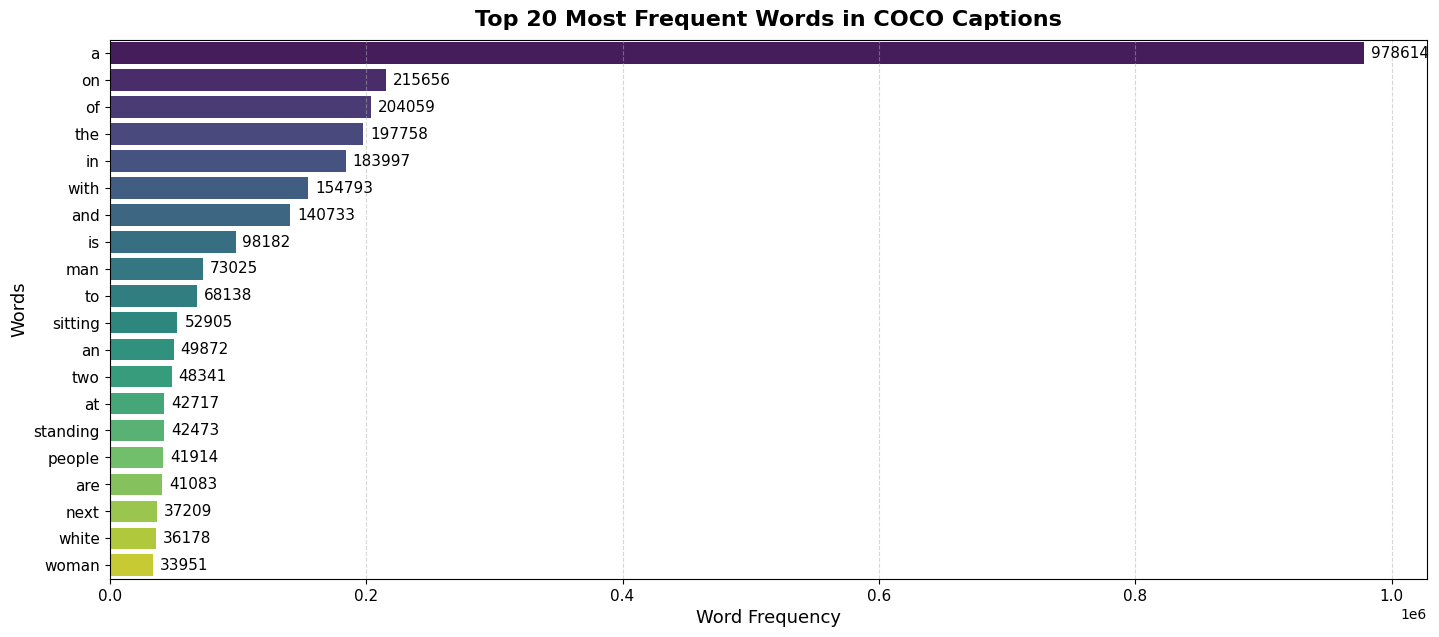

In [ ]:
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

word_freq_df = word_freq_df.sort_values(by="count", ascending=False)
top_words_df = word_freq_df.head(20)

plt.figure(figsize=(17, 7))
ax = sns.barplot(x="count", y="word", data=top_words_df, legend=False, hue ='word', palette="viridis")

plt.title("Top 20 Most Frequent Words in COCO Captions", fontsize=16, fontweight='bold', pad=10)
plt.xlabel("Word Frequency", fontsize=13)
plt.ylabel("Words", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=11, color='black', xytext=(5, 0), 
                textcoords='offset points')

plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()


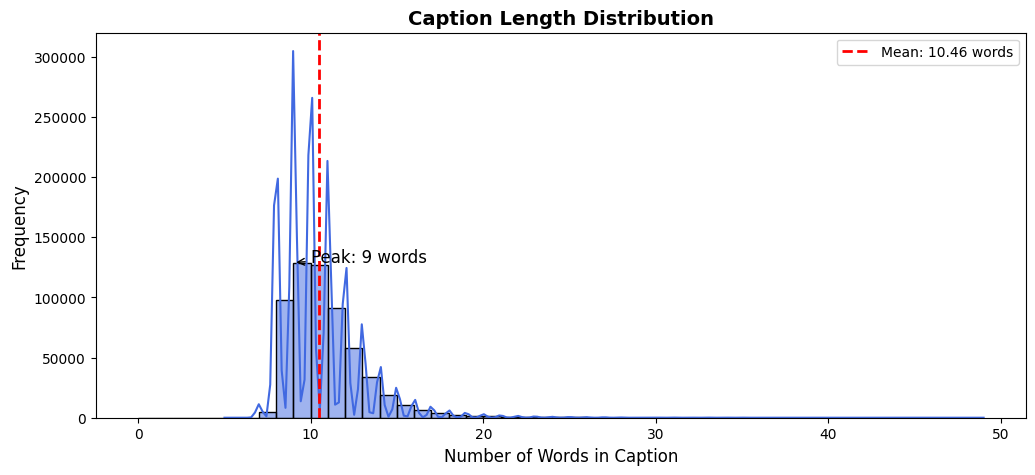

In [ ]:
caption_lengths = [len(caption) for caption in all_captions]

plt.figure(figsize=(12, 5))
ax = sns.histplot(caption_lengths, bins=range(0, max(caption_lengths), 1), kde=True, color="royalblue")

plt.title("Caption Length Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Number of Words in Caption", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

mean_length = sum(caption_lengths) / len(caption_lengths)

plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f"Mean: {mean_length:.2f} words")

max_bin = max(set(caption_lengths), key=caption_lengths.count)
plt.annotate(f"Peak: {max_bin} words", xy=(max_bin, caption_lengths.count(max_bin)), 
             xytext=(max_bin + 1, caption_lengths.count(max_bin) + 30),
             arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=12)

plt.legend()
plt.show()



loading annotations into memory...
Done (t=10.20s)
creating index...
index created!


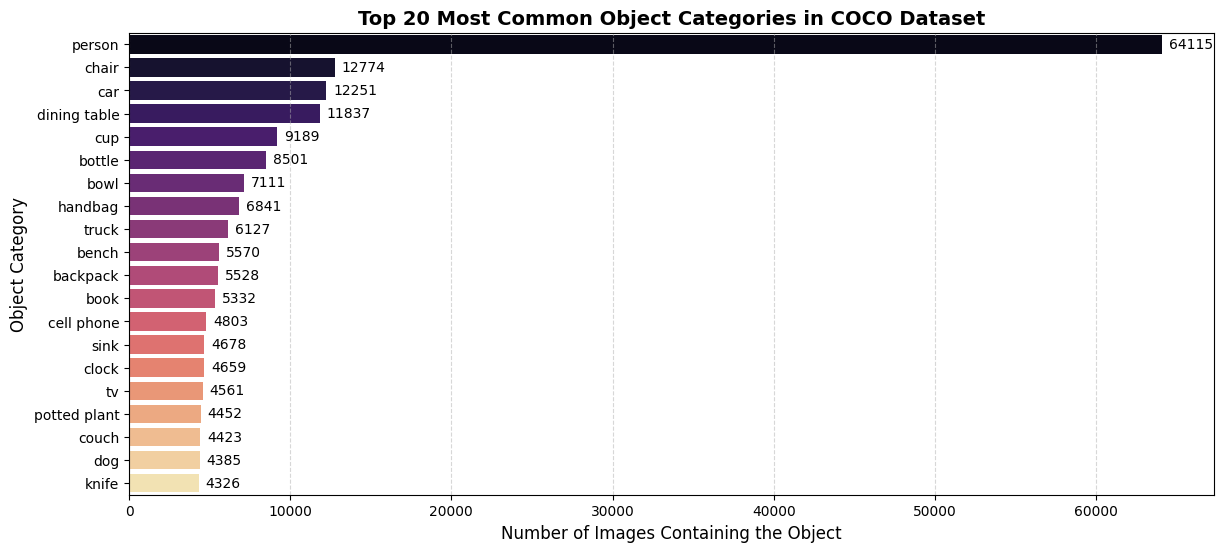

In [ ]:
instances_file = os.path.join(cocoapi_dir, "annotations/instances_train2017.json")
coco_instances = COCO(instances_file)

if not hasattr(coco_instances, "getCatIds"):
    raise ValueError("COCO dataset is not loaded properly. Check 'coco_instances' initialization.")

categories = coco_instances.loadCats(coco_instances.getCatIds())
category_counts = {cat['name']: len(coco_instances.getImgIds(catIds=[cat['id']])) for cat in categories}

category_counts_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

top_categories_df = category_counts_df.nlargest(20, "Count")

plt.figure(figsize=(14, 6))
ax = sns.barplot(x="Count", y="Category", data=top_categories_df, hue="Category", legend=False, palette="magma")


plt.title("Top 20 Most Common Object Categories in COCO Dataset", fontsize=14, fontweight='bold')
plt.xlabel("Number of Images Containing the Object", fontsize=12)
plt.ylabel("Object Category", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), 
                textcoords='offset points')
plt.grid(axis='x', linestyle='--', alpha=0.5)


plt.show()


## Dataset, vocabulary preparation

In [4]:
batch_size = 64 
vocab_threshold = 5  
vocab_from_file = True  
embed_size = 256  
hidden_size = 512  
num_epochs = 1  
save_every = 1  
print_every = 40  
log_file = "training_log.txt"  

In [5]:
transform_train = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225),
        ),
    ]
)
transform_test = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225),
        ),
    ]
)

In [6]:
class Vocabulary(object):
    def __init__(
        self,
        vocab_threshold,
        vocab_file="./vocab.pkl",
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file="../annotations/captions_train2017.json",
        vocab_from_file=False,
    ):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) and self.vocab_from_file:
            with open(self.vocab_file, "rb") as f:
                vocab = pickle.load(f)
            self.word2idx = vocab.word2idx
            self.idx2word = vocab.idx2word
            print("Vocabulary successfully loaded from vocab.pkl file!")
        else:
            self.build_vocab()
            with open(self.vocab_file, "wb") as f:
                pickle.dump(self, f)

    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, idx in enumerate(ids):
            caption = str(coco.anns[idx]["caption"])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [7]:
class CoCoDataset(data.Dataset):
    def __init__(
        self,
        transform,
        mode,
        batch_size,
        vocab_threshold,
        vocab_file,
        start_word,
        end_word,
        unk_word,
        annotations_file,
        vocab_from_file,
        img_folder,
    ):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(
            vocab_threshold,
            vocab_file,
            start_word,
            end_word,
            unk_word,
            annotations_file,
            vocab_from_file,
        )
        self.img_folder = img_folder
        if self.mode == "train":
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print("Obtaining caption lengths...")
            all_tokens = [
                nltk.tokenize.word_tokenize(
                    str(self.coco.anns[self.ids[index]]["caption"]).lower()
                )
                for index in tqdm(np.arange(len(self.ids)))
            ]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item["file_name"] for item in test_info["images"]]

    def __getitem__(self, index):
        # Obtain image and caption if in training mode
        if self.mode == "train":
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]["caption"]
            img_id = self.coco.anns[ann_id]["image_id"]
            path = self.coco.loadImgs(img_id)[0]["file_name"]

            image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            image = self.transform(image)

            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            return image, caption

        elif self.mode == "valid":
            path = self.paths[index]
            image_id = int(path.split("/")[0].split(".")[0].split("_")[-1])
            pil_image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            image = self.transform(pil_image)

            return image_id, image
        # obtain image if in test mode
        else:
            path = self.paths[index]

            pil_image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            orig_image = np.array(pil_image)
            image = self.transform(pil_image)

            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where(
            [
                self.caption_lengths[i] == sel_length
                for i in np.arange(len(self.caption_lengths))
            ]
        )[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == "train":
            return len(self.ids)
        else:
            return len(self.paths)


In [8]:
def get_loader(
    transform,
    mode="valid",
    batch_size=1,
    vocab_threshold=None,
    vocab_file="./vocab.pkl",
    start_word="<start>",
    end_word="<end>",
    unk_word="<unk>",
    vocab_from_file=True,
    num_workers=0,
    cocoapi_loc="/opt",
):
    assert mode in ["train", "valid", "test"], "mode must be one of 'train' or 'test'."
    if not vocab_from_file:
        assert (
            mode == "train"
        ), "To generate vocab from captions file, must be in training mode (mode='train')."

    if mode == "train":
        if vocab_from_file:
            assert os.path.exists(
                vocab_file
            ), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, "images/train2017/")
        annotations_file = os.path.join(
            cocoapi_loc, "annotations/captions_train2017.json"
        )
    elif mode == "test":
        assert batch_size == 1, "Please change batch_size to 1 if testing the model."
        assert os.path.exists(
            vocab_file
        ), "Must first generate vocab.pkl from training data."
        assert vocab_from_file, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, "images/test2017/")
        annotations_file = os.path.join(
            cocoapi_loc, "annotations/image_info_test2017.json"
        )
    elif mode == "valid":
        assert batch_size == 1, "Please change batch_size to 1 if testing the model."
        assert os.path.exists(
            vocab_file
        ), "Must first generate vocab.pkl from training data."
        assert vocab_from_file, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, "images/val2017/")
        annotations_file = os.path.join(
            cocoapi_loc, "annotations/captions_val2017.json"
        )
    else:
        raise ValueError(f"Invalid mode: {mode}")

    dataset = CoCoDataset(
        transform=transform,
        mode=mode,
        batch_size=batch_size,
        vocab_threshold=vocab_threshold,
        vocab_file=vocab_file,
        start_word=start_word,
        end_word=end_word,
        unk_word=unk_word,
        annotations_file=annotations_file,
        vocab_from_file=vocab_from_file,
        img_folder=img_folder,
    )

    if mode == "train":
        indices = dataset.get_train_indices()
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader = data.DataLoader(
            dataset=dataset,
            num_workers=num_workers,
            batch_sampler=data.sampler.BatchSampler(
                sampler=initial_sampler, batch_size=dataset.batch_size, drop_last=False
            ),
        )
    else:
        data_loader = data.DataLoader(
            dataset=dataset,
            batch_size=dataset.batch_size,
            shuffle=True,
            num_workers=num_workers,
        )

    return data_loader

In [9]:
# Building data loaders.

train_data_loader = get_loader(
    transform=transform_train,
    mode="train",
    batch_size=batch_size,
    vocab_threshold=vocab_threshold,
    vocab_from_file=vocab_from_file,
    cocoapi_loc=cocoapi_dir,
)

val_data_loader = get_loader(
    transform=transform_test, mode="valid", cocoapi_loc=cocoapi_dir
)



Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:23<00:00, 25470.48it/s]


Vocabulary successfully loaded from vocab.pkl file!


## LSTM Model

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models


#Encoder 
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


#Decoder 
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()

        self.hidden_dim = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self, features, captions):
        """
        Args:
            features: features tensor. shape is (bs, embed_size)
            captions: captions tensor. shape is (bs, cap_length)
        Returns:
            outputs: scores of the linear layer

        """
        # remove <end> token from captions and embed captions
        cap_embedding = self.embed(
            captions[:, :-1]
        )  

        embeddings = torch.cat((features.unsqueeze(dim=1), cap_embedding), dim=1)

        # getting output i.e. score and hidden layer.
        # first value: all the hidden states throughout the sequence. second value: the most recent hidden state
        lstm_out, self.hidden = self.lstm(
            embeddings
        )  
        outputs = self.linear(lstm_out)  

        return outputs

    def sample(self, inputs, states=None, max_len=20):
        """
        accepts pre-processed image tensor (inputs) and returns predicted
        sentence (list of tensor ids of length max_len)
        Args:
            inputs: shape is (1, 1, embed_size)
            states: initial hidden state of the LSTM
            max_len: maximum length of the predicted sentence

        Returns:
            res: list of predicted words indices
        """
        res = []
        # now we feed the LSTM output and hidden states back into itself to get the caption
        for i in range(max_len):
            lstm_out, states = self.lstm(
                inputs, states
            )  
            outputs = self.linear(lstm_out.squeeze(dim=1))  # outputs: (1, vocab_size)
            _, predicted_idx = outputs.max(dim=1)  # predicted: (1, 1)
            res.append(predicted_idx.item())
            # if the predicted idx is the stop index, the loop stops
            if predicted_idx == 1:
                break
            inputs = self.embed(predicted_idx)  # inputs: (1, embed_size)
            # prepare input for next iteration
            inputs = inputs.unsqueeze(1)  # inputs: (1, 1, embed_size)

        return res


In [11]:

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
def clean_sentence(output, idx2word):
    sentence = ""
    for i in output:
        word = idx2word[i]
        if i == 0:
            continue
        if i == 1:
            break
        if i == 18:
            sentence = sentence + word
        else:
            sentence = sentence + " " + word
    return sentence

def bleu_score(true_sentences, predicted_sentences):
    hypotheses = []
    references = []
    for img_id in set(true_sentences.keys()).intersection(
        set(predicted_sentences.keys())
    ):
        img_refs = [cap.split() for cap in true_sentences[img_id]]
        references.append(img_refs)
        hypotheses.append(predicted_sentences[img_id][0].strip().split())
        
    score_bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    score_bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    print(f"BLEU-1: {score_bleu1}, BLEU-2: {score_bleu2}")
    return corpus_bleu(references, hypotheses)


### Training

In [14]:
vocab_size = len(train_data_loader.dataset.vocab)
print("vocab size is : ",vocab_size)

# Initializing the encoder and decoder
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

criterion = (
    nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
)

params = list(decoder.parameters()) + list(encoder.embed.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

total_step = math.ceil(len(train_data_loader.dataset) / train_data_loader.batch_sampler.batch_size)
print(total_step)

vocab size is :  10321
9247


In [ ]:
#Build ground-truth captions dictionary from validation annotations
val_annotations_file = os.path.join(cocoapi_dir, "annotations/captions_val2017.json")
from pycocotools.coco import COCO
val_coco = COCO(val_annotations_file)

true_sentences = {}
ann_ids = val_coco.getAnnIds()
annotations = val_coco.loadAnns(ann_ids)
for ann in annotations:
    img_id = ann["image_id"]
    if img_id not in true_sentences:
        true_sentences[img_id] = []
    true_sentences[img_id].append(ann["caption"])

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [ ]:
# Load model checkpoints
encoder.load_state_dict(torch.load(os.path.join("./models", "encoder-5.pkl")))
decoder.load_state_dict(torch.load(os.path.join("./models", "decoder-5.pkl")))
encoder.to(device)
decoder.to(device)

optimizer = torch.optim.Adam(params, lr=0.001)
if os.path.exists(os.path.join("./models", "optimizer-5.pth")):
    optimizer.load_state_dict(torch.load(os.path.join("./models", "optimizer-5.pth")))

In [ ]:
f = open(log_file, "a+")
num_epochs = 1 

start_epoch = 5
num_epochs = 1

for epoch in range(start_epoch, num_epochs + start_epoch):
    decoder.train()
    encoder.train()
    
    print(f"\nEpoch {epoch}/{num_epochs + start_epoch - 1}")
    progress_bar = tqdm(range(1, total_step + 1), desc="Training", unit="step")
    
    for i_step in progress_bar:
        indices = train_data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        train_data_loader.batch_sampler.sampler = new_sampler

        images, captions = next(iter(train_data_loader))
        images = images.to(device)
        captions = captions.to(device)

        decoder.zero_grad()
        encoder.zero_grad()

        features = encoder(images)
        outputs = decoder(features, captions)

        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Perplexity": f"{np.exp(loss.item()):.4f}"
        })

        stats = (
            f"Epoch [{epoch}/{num_epochs}], Step [{i_step}/{total_step}], "
            f"Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):.4f}"
        )
        f.write(stats + "\n")
        f.flush()
    
    
    # save model checkpoints.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join("./models", f"decoder-{epoch}.pkl"))
        torch.save(encoder.state_dict(), os.path.join("./models", f"encoder-{epoch}.pkl"))

f.close()



Epoch 5/5


Training: 100%|██████████| 9247/9247 [2:26:49<00:00,  1.05step/s, Loss=1.9753, Perplexity=7.2089]   


In [58]:
torch.save(optimizer.state_dict(), os.path.join("./models", f"optimizer-{epoch}.pth"))


In [12]:
vocab_file = "vocab.pkl"
with open(vocab_file, "rb") as f:
    vocab = pickle.load(f)

In [ ]:
with open(
    os.path.join(cocoapi_dir, "annotations/captions_val2017.json"), "r"
) as f:
    caption = json.load(f)

valid_annot = caption["annotations"]
valid_result = defaultdict(list)
for i in valid_annot:
    valid_result[i["image_id"]].append(i["caption"].lower())

In [ ]:
def get_image_by_id(dataset, target_img_id):
    for img_id, image in dataset:
        if img_id == target_img_id:
            return image
    return None

image = get_image_by_id(val_data_loader.dataset, 190236)

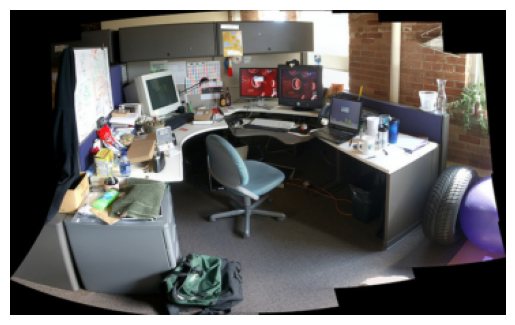

In [ ]:
def imshow(image_tensor):
    image_np = image_tensor.cpu().numpy()
    image_np = np.transpose(image_np, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    plt.imshow(image_np)
    plt.axis("off")
    plt.show()

imshow(image)

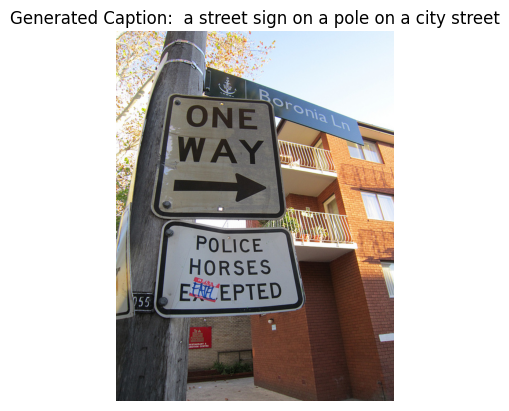

In [13]:
from PIL import Image
import torch
from torchvision import transforms
import os
import pickle
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embed_size = 256  
hidden_size = 512  
vocab_file = "vocab.pkl"  

with open(vocab_file, "rb") as f:
    vocab = pickle.load(f)

vocab_size = len(vocab)

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

encoder.to(device)
decoder.to(device)

encoder_file = "encoder-5.pkl"  
decoder_file = "decoder-5.pkl"  

encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file)))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file)))

encoder.eval()
decoder.eval()

test_image_path = r"D:\DLproject\myproject\4.jpg"  
test_image = Image.open(test_image_path).convert("RGB")

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_image = transform_test(test_image).unsqueeze(0)  
test_image = test_image.to(device)
with torch.no_grad():
    features = encoder(test_image).unsqueeze(1)

with torch.no_grad():
    output = decoder.sample(features)

caption = clean_sentence(output, vocab.idx2word)

plt.imshow(Image.open(test_image_path))
plt.axis('off')
plt.title('Generated Caption: ' + caption)
plt.show()


## GRU 

In [14]:
class EncoderGRU(nn.Module):
    def __init__(self, embed_size):
        super(EncoderGRU, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad = False  # In order to use pre-trained weights
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    
    def forward(self, images):
        features = self.feature_extractor(images)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return self.bn(features)
    
class DecoderGRU(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderGRU, self).__init__()
        self.hidden_dim = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden = torch.zeros(num_layers, 1, hidden_size)

    def forward(self, features, captions):
        cap_embedding = self.embed(captions[:, :-1])
        embeddings = torch.cat((features.unsqueeze(dim=1), cap_embedding), dim=1)
        gru_out, _ = self.gru(embeddings)
        outputs = self.linear(gru_out)
        return outputs

    def sample(self, inputs, states=None, max_len=20):
        res = []
        for i in range(max_len):
            gru_out, states = self.gru(inputs, states)
            outputs = self.linear(gru_out.squeeze(dim=1))
            _, predicted_idx = outputs.max(dim=1)
            res.append(predicted_idx.item())
            if predicted_idx == 1:
                break
            inputs = self.embed(predicted_idx).unsqueeze(1)
        return res

vocab_size = len(train_data_loader.dataset.vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = EncoderGRU(embed_size).to(device)
decoder = DecoderGRU(embed_size, hidden_size, vocab_size).to(device)

In [ ]:
encoder.load_state_dict(torch.load(os.path.join("./models", "encoder_gru-5.pkl")))
decoder.load_state_dict(torch.load(os.path.join("./models", "decoder_gru-5.pkl")))

encoder.to(device)
decoder.to(device)

optimizer = torch.optim.Adam(params, lr=0.001)
if os.path.exists(os.path.join("./models", "optimizer-5.pth")):
    optimizer.load_state_dict(torch.load(os.path.join("./models", "optimizer_gru-5.pth")))

In [ ]:
criterion = (
    nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
)

params = list(decoder.parameters()) + list(encoder.fc.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

total_step = math.ceil(len(train_data_loader.dataset) / train_data_loader.batch_sampler.batch_size)
print(total_step)

In [ ]:
f = open(log_file, "a+")
num_epochs = 1  
start_epoch = 5

for epoch in range(start_epoch, start_epoch + num_epochs):
    decoder.train()
    encoder.train()
    print(f"\nEpoch {epoch}/{start_epoch + num_epochs - 1}")
    progress_bar = tqdm(range(1, total_step + 1), desc="Training", unit="step")

    for i_step in progress_bar:
        indices = train_data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        train_data_loader.batch_sampler.sampler = new_sampler

        images, captions = next(iter(train_data_loader))
        images = images.to(device)
        captions = captions.to(device)

        decoder.zero_grad()
        encoder.zero_grad()

        features = encoder(images)
        outputs = decoder(features, captions)

        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Perplexity": f"{np.exp(loss.item()):.4f}"
        })

        stats = (
            f"Epoch [{epoch}/{num_epochs}], Step [{i_step}/{total_step}], "
            f"Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):.4f}"
        )
        f.write(stats + "\n")
        f.flush()

    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join("./models", f"decoder_gru-{epoch}.pkl"))
        torch.save(encoder.state_dict(), os.path.join("./models", f"encoder_gru-{epoch}.pkl"))
        torch.save(optimizer.state_dict(), os.path.join("./models", f"optimizer_gru-{epoch}.pth"))

f.close()

## LSTM with Attention

In [15]:
import torch.nn.functional as F
# Attention mechanism
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim=512):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        # encoder_out shape: (batch_size, 1, encoder_dim)
        # decoder_hidden shape: (batch_size, decoder_dim)
        
        att1 = self.encoder_att(encoder_out)  
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1) 
        
        # Calculate attention scores
        att = self.full_att(self.relu(att1 + att2))  
        alpha = self.softmax(att)  
        
        # Weight encoder outputs with attention scores
        context = (encoder_out * alpha).sum(dim=1) 
        
        return context, alpha

# Encoder 
class EncoderATT(nn.Module):
    def __init__(self, embed_size):
        super(EncoderATT, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        for param in self.resnet.parameters():
            param.requires_grad_(False)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        features = self.bn(features)
        return features

# Decoder with LSTM and Attention
class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super(DecoderLSTMWithAttention, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(p=dropout)
        
        # Attention mechanism
        self.attention = Attention(embed_size, hidden_size)
        
        # LSTM cell
        self.lstm = nn.LSTM(embed_size + embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Final classifier
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embedding(captions[:, :-1]))
        
        if features.dim() == 3:
            features = features.squeeze(1)

        batch_size = captions.size(0)
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(features.device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(features.device)

        features_for_attn = features.unsqueeze(1)

        outputs = []
        
        h_t = h[-1]  # Last layer hidden state
        
        for t in range(embeddings.size(1)):
            context, alpha = self.attention(features_for_attn, h_t)
            # Combine embedding and context
            lstm_input = torch.cat((embeddings[:, t, :], context), dim=1).unsqueeze(1)
            # LSTM step
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            h_t = h[-1]  
            # Project to vocabulary
            output = self.fc(lstm_out.squeeze(1))
            outputs.append(output)
            
        return torch.stack(outputs, dim=1)
    
    def sample(self, features, states=None, max_len=20, temperature=1.0, beam_size=5):
        if beam_size > 1:
            return self._beam_search(features, max_len, beam_size)
        else:
            return self._greedy_search(features, states, max_len, temperature)
    
    def _greedy_search(self, features, states=None, max_len=20, temperature=1.0):
        if features.dim() == 3:
            features = features.squeeze(1)
            
        batch_size = features.size(0)

        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(features.device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(features.device)

        features_for_attn = features.unsqueeze(1)       
        # Start with <start> token
        inputs = torch.ones(batch_size, 1).long().to(features.device) * 0
        sampled_ids = []

        h_t = h[-1]  
        
        for i in range(max_len):
            embeddings = self.embedding(inputs).squeeze(1)
            context, alpha = self.attention(features_for_attn, h_t)
            lstm_input = torch.cat((embeddings, context), dim=1).unsqueeze(1)
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            h_t = h[-1] 
            
            # Get prediction
            outputs = self.fc(lstm_out.squeeze(1))

            if temperature != 1.0:
                outputs = outputs / temperature

            _, predicted = outputs.max(dim=1)
            sampled_ids.append(predicted)
            if (predicted == 1).all():  # <end> token
                break

            inputs = predicted.unsqueeze(1)

        sampled_ids = torch.stack(sampled_ids, dim=1)
        return sampled_ids
    
    def _beam_search(self, features, max_len=20, beam_size=5):
        """Generate captions using beam search for better quality"""
        if features.dim() == 3:
            features = features.squeeze(1)
            
        k = beam_size
        device = features.device
        
        features_for_attn = features.unsqueeze(1)

        outputs = []
        
        for i in range(features.size(0)):
            feature = features[i:i+1]
            feature_attn = features_for_attn[i:i+1]

            h = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
            c = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)

            start_token = torch.ones(1).long().to(device) * 0

            embedding = self.embedding(start_token)
            h_t = h[-1] 

            context, _ = self.attention(feature_attn, h_t)
            lstm_input = torch.cat((embedding, context), dim=1).unsqueeze(1)
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            
            outputs_t = F.log_softmax(self.fc(lstm_out.squeeze(1)), dim=1)
            log_probs, indices = outputs_t.topk(k, dim=1)
            
            beams = [(log_probs[0, j].item(), [indices[0, j].item()], h, c) for j in range(k)]

            for step in range(1, max_len):
                temp_beams = []
                
                for b in range(len(beams)):
                    log_prob, seq, h_prev, c_prev = beams[b]
                    
                    if seq[-1] == 1: 
                        temp_beams.append(beams[b])
                        continue
                    last_token = torch.LongTensor([seq[-1]]).to(device)

                    embedding = self.embedding(last_token)

                    h_t = h_prev[-1]  
                    context, _ = self.attention(feature_attn, h_t)

                    lstm_input = torch.cat((embedding, context), dim=1).unsqueeze(1)
                    lstm_out, (h_new, c_new) = self.lstm(lstm_input, (h_prev, c_prev))

                    outputs_t = F.log_softmax(self.fc(lstm_out.squeeze(1)), dim=1)
                    next_log_probs, next_indices = outputs_t.topk(k, dim=1)
                    
                    for j in range(k):
                        new_log_prob = log_prob + next_log_probs[0, j].item()
                        new_seq = seq + [next_indices[0, j].item()]
                        temp_beams.append((new_log_prob, new_seq, h_new, c_new))
                
                temp_beams.sort(key=lambda x: -x[0])
                beams = temp_beams[:k]

                if all(b[1][-1] == 1 for b in beams):
                    break

            best_beam = max(beams, key=lambda x: x[0])
            outputs.append(best_beam[1])

        max_length = max(len(o) for o in outputs)
        padded_outputs = torch.zeros(len(outputs), max_length).long().to(device)
        for i, output in enumerate(outputs):
            padded_outputs[i, :len(output)] = torch.LongTensor(output).to(device)
            
        return padded_outputs

In [111]:
vocab_size = len(train_data_loader.dataset.vocab)
embed_size = 256
hidden_size = 512
num_layers = 2
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EncoderATT(embed_size).to(device)
decoder = DecoderLSTMWithAttention(embed_size, hidden_size, vocab_size, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss().to(device)

params = list(decoder.parameters()) + list(encoder.fc.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

total_step = math.ceil(len(train_data_loader.dataset) / train_data_loader.batch_sampler.batch_size)
print(f"Total steps per epoch: {total_step}")

os.makedirs("./models", exist_ok=True)

log_file = "training_log.txt"
save_every = 1  

Total steps per epoch: 9247


c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
encoder.load_state_dict(torch.load(os.path.join("./models", "encoder_cnn-5.pkl")))
decoder.load_state_dict(torch.load(os.path.join("./models", "decoder_lstm_attn-5.pkl")))

optimizer = torch.optim.Adam(params, lr=0.001)
if os.path.exists(os.path.join("./models", "optimizer_lstm_att-1.pth")):
    optimizer.load_state_dict(torch.load(os.path.join("./models", "optimizer_attn-5.pth")))

In [ ]:
# Training loop 
f = open(log_file, "a+")
num_epochs = 1  
start_epoch = 5  

train_losses = []
val_losses = []
bleu_scores = []

for epoch in range(start_epoch, start_epoch + num_epochs):
    decoder.train()
    encoder.train()
    
    epoch_loss = 0.0
    epoch_perplexity = 0.0
    
    print(f"\nEpoch {epoch+1}/{start_epoch + num_epochs}")
    progress_bar = tqdm(range(1, total_step + 1), desc="Training", unit="step")

    for i_step in progress_bar:
        indices = train_data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        train_data_loader.batch_sampler.sampler = new_sampler

        images, captions = next(iter(train_data_loader))
        images = images.to(device)
        captions = captions.to(device)

        decoder.zero_grad()
        encoder.zero_grad()

        features = encoder(images)
        outputs = decoder(features, captions)


        targets = captions[:, 1:]  # Exclude the <start> token
        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
        
        optimizer.step()

        current_loss = loss.item()
        current_perplexity = np.exp(current_loss)
        epoch_loss += current_loss
        epoch_perplexity += current_perplexity


        progress_bar.set_postfix({
            "Loss": f"{current_loss:.4f}",
            "Perplexity": f"{current_perplexity:.4f}"
        })

        stats = (
            f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Step [{i_step}/{total_step}], "
            f"Loss: {current_loss:.4f}, Perplexity: {current_perplexity:.4f}"
        )
        f.write(stats + "\n")
        f.flush()

    avg_epoch_loss = epoch_loss / total_step
    avg_epoch_perplexity = epoch_perplexity / total_step
    train_losses.append(avg_epoch_loss)
    
    print(f"Epoch {epoch+1} - Average Loss: {avg_epoch_loss:.4f}, Average Perplexity: {avg_epoch_perplexity:.4f}")

    if (epoch + 1) % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join("./models", f"decoder_lstm_attn-{epoch+1}.pkl"))
        torch.save(encoder.state_dict(), os.path.join("./models", f"encoder_cnn-{epoch+1}.pkl"))
        torch.save(optimizer.state_dict(), os.path.join("./models", f"optimizer_attn-{epoch+1}.pth"))
        
        print(f"Model checkpoint saved at epoch {epoch+1}")

f.close()

print("Training complete!")


Epoch 6/6


Training:  27%|██▋       | 2538/9247 [2:30:10<14:17:06,  7.67s/step, Loss=2.1731, Perplexity=8.7859]     

# Evaluation (Generate caption on images and calculating BLeU score)

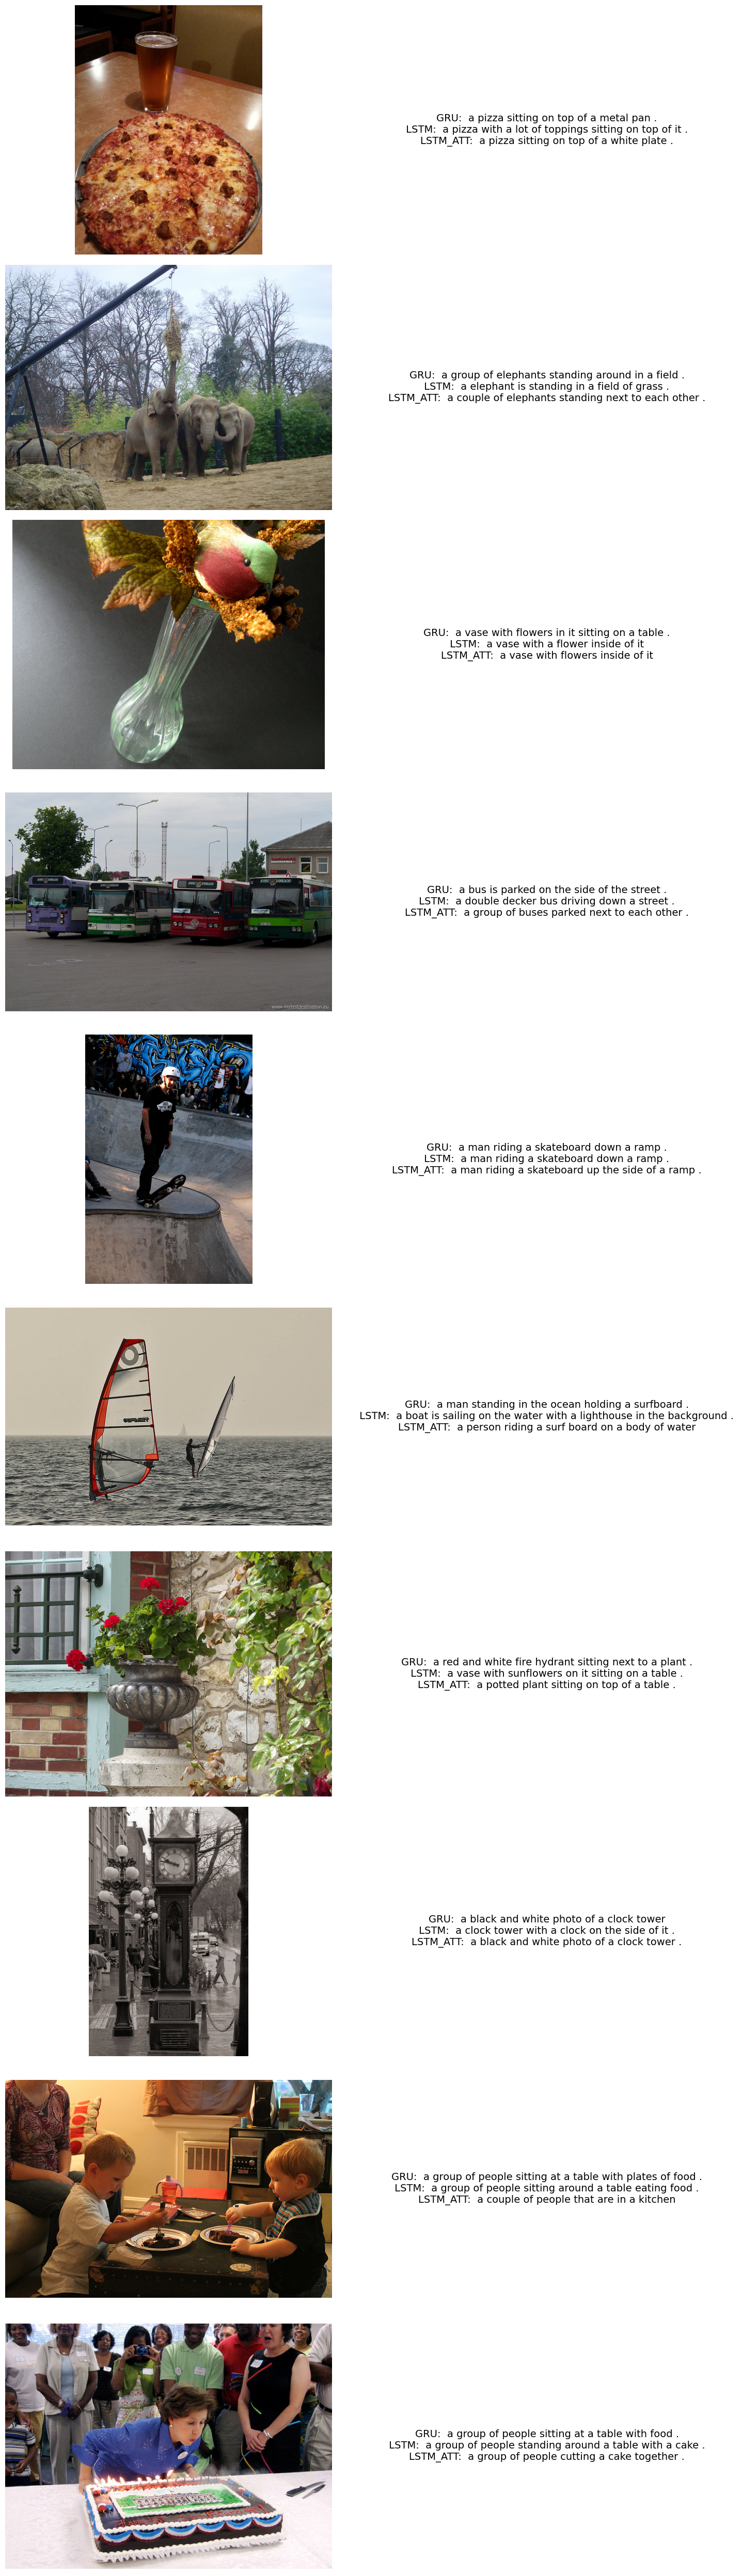

In [22]:
import os
import random
import pickle
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


embed_size = 256 
hidden_size = 512  
vocab_file = "vocab.pkl"  
image_folder = r"D:\DLproject\coco2017\images\test2017"  

with open(vocab_file, "rb") as f:
    vocab = pickle.load(f)

vocab_size = len(vocab)

encoder1 = EncoderGRU(embed_size)
decoder1 = DecoderGRU(embed_size, hidden_size, vocab_size)

encoder2 = EncoderCNN(embed_size)
decoder2 = DecoderRNN(embed_size, hidden_size, vocab_size)

encoder3 = EncoderATT(embed_size).to(device)
decoder3 = DecoderLSTMWithAttention(embed_size, hidden_size, vocab_size, num_layers=2, dropout=0.5).to(device)

encoder1.to(device)
decoder1.to(device)
encoder2.to(device)
decoder2.to(device)


encoder1.load_state_dict(torch.load(os.path.join("./models", "encoder_gru-5.pkl")))
decoder1.load_state_dict(torch.load(os.path.join("./models", "decoder_gru-5.pkl")))

encoder2.load_state_dict(torch.load(os.path.join("./models", "encoder-5.pkl")))
decoder2.load_state_dict(torch.load(os.path.join("./models", "decoder-5.pkl")))

encoder3.load_state_dict(torch.load(os.path.join("./models", "encoder_cnn-5.pkl")))
decoder3.load_state_dict(torch.load(os.path.join("./models", "decoder_lstm_attn-5.pkl")))

encoder1.eval()
decoder1.eval()
encoder2.eval()
decoder2.eval()
encoder3.eval()
decoder3.eval()

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

image_files = random.sample(os.listdir(image_folder), 10)

fig, axes = plt.subplots(10, 2, figsize=(15, 50))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path).convert("RGB")

    image_tensor = transform_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features1 = encoder1(image_tensor).unsqueeze(1)
        output1 = decoder1.sample(features1)
    caption1 = clean_sentence(output1, vocab.idx2word)

    with torch.no_grad():
        features2 = encoder2(image_tensor).unsqueeze(1)
        output2 = decoder2.sample(features2)
    caption2 = clean_sentence(output2, vocab.idx2word)
    
    with torch.no_grad():
        features3 = encoder3(image_tensor).unsqueeze(1)
        output3 = decoder3.sample(features3)
    caption3 = clean_sentence(output3[0].cpu().numpy(), vocab.idx2word)

    axes[i, 0].imshow(image)
    axes[i, 0].axis("off")
    
    caption_text = f"GRU: {caption1}\n LSTM: {caption2} \nLSTM_ATT: {caption3}"
    axes[i, 1].text(0.5, 0.5, caption_text, fontsize=14, ha='center', va='center', wrap=True)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [19]:
with open(
    os.path.join(cocoapi_dir, "annotations/captions_val2017.json"), "r"
) as f:
    caption = json.load(f)

valid_annot = caption["annotations"]
valid_result = defaultdict(list)
for i in valid_annot:
    valid_result[i["image_id"]].append(i["caption"].lower())

FOR GRU 

In [78]:
# infer captions for all images
pred_result1 = defaultdict(list)
for img_id, img in tqdm(val_data_loader):
    img = img.to(device)
    with torch.no_grad():
        features = encoder1(img).unsqueeze(1)
        output = decoder1.sample(features)
    sentence = clean_sentence(output, vocab.idx2word)
    pred_result1[img_id.item()].append(sentence)

100%|██████████| 5000/5000 [02:03<00:00, 40.47it/s]


In [80]:
bleu_score(valid_result, pred_result1)   

BLEU-1: 0.5976002341235002, BLEU-2: 0.4263112373273379


0.20590493472293153

FOR LSTM

In [17]:
# infer captions for all images
pred_result1 = defaultdict(list)
for img_id, img in tqdm(val_data_loader):
    img = img.to(device)
    with torch.no_grad():
        features = encoder2(img).unsqueeze(1)
        output = decoder2.sample(features)
    sentence = clean_sentence(output, vocab.idx2word)
    pred_result1[img_id.item()].append(sentence)

100%|██████████| 5000/5000 [07:35<00:00, 10.97it/s]


In [20]:
bleu_score(valid_result, pred_result1)   

BLEU-1: 0.5875629790821227, BLEU-2: 0.4087672400938484


0.1847264816022199

FOR LSTM-ATT

In [23]:
# infer captions for all images
pred_result3 = defaultdict(list)
for img_id, img in tqdm(val_data_loader):
    img = img.to(device)
    with torch.no_grad():
        features = encoder3(img).unsqueeze(1)
        output = decoder3.sample(features)
    sentence = clean_sentence(output[0].cpu().numpy(), vocab.idx2word)
    pred_result3[img_id.item()].append(sentence)

100%|██████████| 5000/5000 [17:41<00:00,  4.71it/s] 


In [24]:
bleu_score(valid_result, pred_result3)

BLEU-1: 0.6072526622279234, BLEU-2: 0.43787060961684304


0.22952120945017135